In [31]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime
import plotly as pt
import plotly.graph_objects as go
from plotly.offline import iplot
from scipy import signal
from scipy.stats import norm

In [2]:
data1 = pd.read_csv("../../../Data/2022_08_09_Tides_Grav/2022_0809_0908_grav.csv", parse_dates=[0])
data2 = pd.read_csv("../../../Data/2022_08_09_Tides_Grav/2022_0908_1008_grav.csv", parse_dates=[0])
data3 = pd.read_csv("../../../Data/2022_08_09_Tides_Grav/2022_1007_1106_grav.csv", skiprows=2 ,parse_dates=[0])
data4 = pd.read_csv("../../../Data/2022_08_09_Tides_Grav/2022_1105_1205_grav.csv", skiprows=2 ,parse_dates=[0])

tides = pd.concat([data1, data2,data3, data4])
tides.rename(columns={'Datetime[UTC+0.0h]':'Datetime', 
                      'Signal [nm/s**2]': 'Signal', 
                      'Tide [nm/s**2]': 'Tide', 
                      'Pole tide [nm/s**2]' : 'Pole_tide', 
                      'LOD tide [nm/s**2]'  : 'LOD_tide'
                     }, inplace=True)
tides.drop_duplicates('Datetime', inplace=True)
tides

Datetime      Signal        Tide  Pole_tide  LOD_tide
0     2022-08-09 00:00:00  861.462922  818.384908  43.421935 -0.343921
1     2022-08-09 00:01:00  861.306205  818.228048  43.422079 -0.343922
2     2022-08-09 00:02:00  861.141826  818.063526  43.422222 -0.343922
3     2022-08-09 00:03:00  860.969657  817.891214  43.422366 -0.343923
4     2022-08-09 00:04:00  860.789571  817.710985  43.422509 -0.343923
...                   ...         ...         ...        ...       ...
43196 2022-12-04 23:56:00 -280.336783 -299.690992  19.316021  0.038188
43197 2022-12-04 23:57:00 -276.557327 -295.911155  19.315687  0.038141
43198 2022-12-04 23:58:00 -272.761100 -292.114548  19.315354  0.038095
43199 2022-12-04 23:59:00 -268.948317 -288.301385  19.315020  0.038048
43200 2022-12-05 00:00:00 -265.119207 -284.471895  19.314686  0.038001

[169921 rows x 5 columns]

In [3]:
df_geolore = pd.read_pickle('../../../Data/2022_09_13_spiekeroog/Geolore/Pickel/df_with_time.pkl' )
df_geolore_december = pd.read_pickle('../../../Data/2022_12_03_spiekeroog/Geolore/df_with_time.pkl' )

df_60s_bd = df_geolore.resample("1min").last()
df_60s_ad = df_geolore_december.resample("1min").last()

df = pd.concat([df_geolore, df_geolore_december])
df = df[~df.index.duplicated(keep='first')]
df_60s = df.resample("1min").last()
df_30s = df.resample("30s").last()
df_60s_smooth = df_60s.rolling(50).mean().dropna()

In [4]:
df_60s_smooth = df_60s.rolling(50).mean().dropna()
df_60s_smooth
df_60s_median = df_60s.rolling(60*5).median

2         3         4
1                                                
2022-08-10 14:24:00 -0.003677 -0.015808 -0.002378
2022-08-10 14:25:00 -0.003507 -0.016360 -0.002059
2022-08-10 14:26:00 -0.003347 -0.016924 -0.001752
2022-08-10 14:27:00 -0.003187 -0.017486 -0.001444
2022-08-10 14:28:00 -0.003032 -0.018053 -0.001141
...                       ...       ...       ...
2022-12-03 13:01:00  0.013176 -0.036919 -0.001119
2022-12-03 13:02:00  0.013189 -0.036923 -0.001121
2022-12-03 13:03:00  0.013205 -0.036922 -0.001121
2022-12-03 13:04:00  0.013221 -0.036922 -0.001119
2022-12-03 13:05:00  0.013237 -0.036922 -0.001119

[165522 rows x 3 columns]

## Normalized data

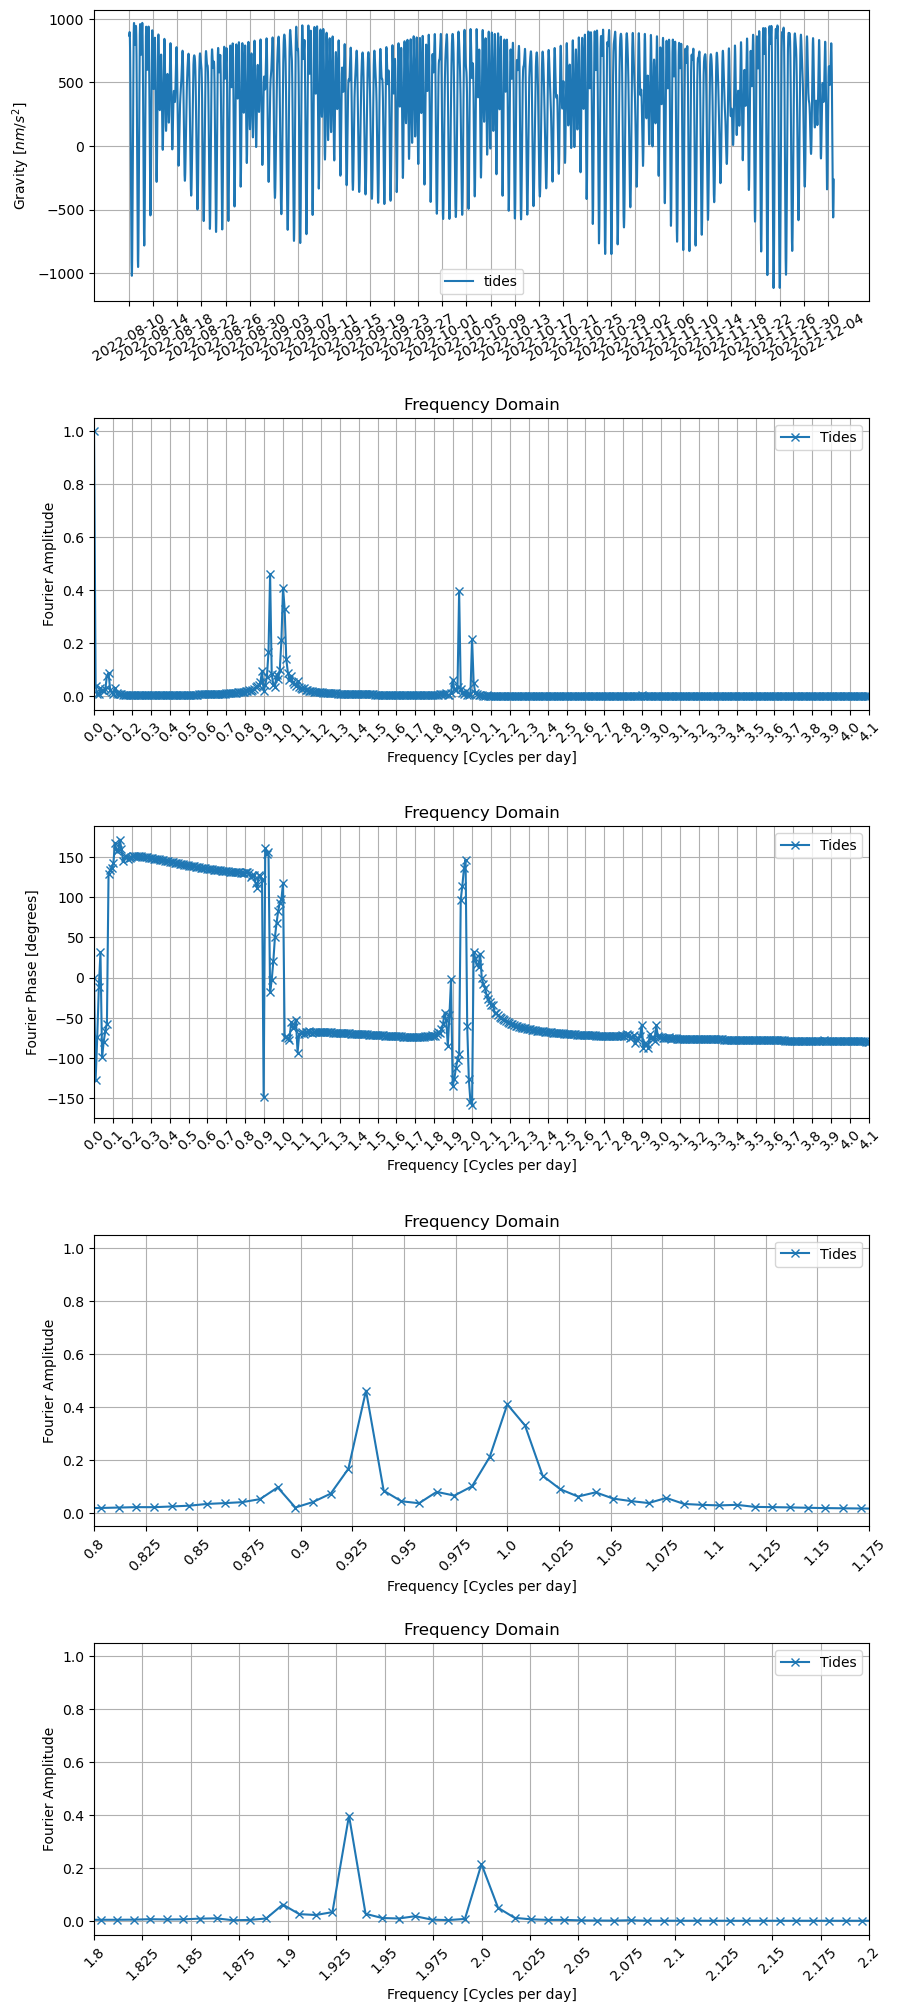

In [5]:
start_date = datetime.datetime(2022,8,10)
end_date = datetime.datetime(2022,12,5)

days = np.arange(np.datetime64(np.datetime_as_string(np.datetime64(start_date))[:10]),
         np.datetime64(np.datetime_as_string(np.datetime64(end_date+datetime.timedelta(days=1)))[:10]), 4)

tides_dated = tides[(tides['Datetime']>=start_date) &  (tides['Datetime']<=end_date)]
si = 60
X = tides_dated['Signal'].values
N = len(X)
F = np.fft.fft(X)/N
F_freq = np.fft.fftfreq(N, d=si)

one_side = N//2

fig , axes = plt.subplots(5, figsize=(10,5*5))
plt.subplots_adjust(hspace= 0.4)

ax = axes[0]

ax.plot(tides_dated['Datetime'] , tides_dated['Signal'], label="tides")
ax.set_xticks(days)
ax.tick_params('x',rotation=30)
ax.set_ylabel(r'Gravity $[nm/s^2]$')
ax.legend()
ax.grid()

ax = axes[1]
ax.plot(F_freq[:one_side], np.abs(F[:one_side])/max(np.abs(F[:one_side])), "x-", label='Tides')

#x_freq_bot = 0
#x_freq_top = 0.00005
#ax.set_xlim(x_freq_bot, x_freq_top)
#x_freq_ticks = np.linspace(x_freq_bot, x_freq_top,30 )
#ax.set_xticks(x_freq_ticks, labels=np.round(x_freq_ticks*(24*60*60), 3))

x_freq_cpd = np.arange(0,4.2,0.1)
x_freq_hz = x_freq_cpd/(24*60*60)
ax.set_xlim(x_freq_hz[0], x_freq_hz[-1])
ax.set_xticks(x_freq_hz, labels= np.round(x_freq_cpd,1))
ax.tick_params('x',rotation=45)
ax.set_xlabel("Frequency [Cycles per day]")
ax.set_title('Frequency Domain')
ax.set_ylabel("Fourier Amplitude")
ax.legend()    
ax.grid()

ax = axes[2]
ax.plot(F_freq[:one_side], np.angle(F[:one_side])*180/np.pi, "x-", label='Tides')

#x_freq_bot = 0
#x_freq_top = 0.00005
#ax.set_xlim(x_freq_bot, x_freq_top)
#x_freq_ticks = np.linspace(x_freq_bot, x_freq_top,30 )
#ax.set_xticks(x_freq_ticks, labels=np.round(x_freq_ticks*(24*60*60), 3))

x_freq_cpd = np.arange(0,4.2,0.1)
x_freq_hz = x_freq_cpd/(24*60*60)
ax.set_xlim(x_freq_hz[0], x_freq_hz[-1])
ax.set_xticks(x_freq_hz, labels= np.round(x_freq_cpd,1))
ax.tick_params('x',rotation=45)
ax.set_xlabel("Frequency [Cycles per day]")
ax.set_title('Frequency Domain')
ax.set_ylabel("Fourier Phase [degrees]")
ax.legend()    
ax.grid()

ax = axes[3]
ax.plot(F_freq[:one_side], np.abs(F[:one_side])/max(np.abs(F[:one_side])), "x-", label='Tides')

#x_freq_bot = 1 * 10 **(-5)
#x_freq_top = 1.2 * 10 **(-5)
#ax.set_xlim(x_freq_bot, x_freq_top)
#x_freq_ticks = np.linspace(x_freq_bot, x_freq_top,30 )
#ax.set_xticks(x_freq_ticks, labels=np.round(x_freq_ticks*(24*60*60), 3))

x_freq_cpd = np.arange(0.8,1.2,0.025)
x_freq_hz = x_freq_cpd/(24*60*60)
ax.set_xlim(x_freq_hz[0], x_freq_hz[-1])
ax.set_xticks(x_freq_hz, labels= np.round(x_freq_cpd,3))
ax.tick_params('x',rotation=45)
ax.set_xlabel("Frequency [Cycles per day]")
ax.set_title('Frequency Domain')
ax.set_ylabel("Fourier Amplitude")
ax.legend()    
ax.grid()

ax = axes[4]
ax.plot(F_freq[:one_side], np.abs(F[:one_side])/max(np.abs(F[:one_side])), "x-", label='Tides')

#x_freq_bot = 1 * 10 **(-5)
#x_freq_top = 1.2 * 10 **(-5)
#ax.set_xlim(x_freq_bot, x_freq_top)
#x_freq_ticks = np.linspace(x_freq_bot, x_freq_top,30 )
#ax.set_xticks(x_freq_ticks, labels=np.round(x_freq_ticks*(24*60*60), 3))

x_freq_cpd = np.arange(1.8,2.2,0.025)
x_freq_hz = x_freq_cpd/(24*60*60)
ax.set_xlim(x_freq_hz[0], x_freq_hz[-1])
ax.set_xticks(x_freq_hz, labels= np.round(x_freq_cpd,3))
ax.tick_params('x',rotation=45)
ax.set_xlabel("Frequency [Cycles per day]")
ax.set_title('Frequency Domain')
ax.set_ylabel("Fourier Amplitude")
ax.legend()    
ax.grid()
#fig.savefig("Output/Tides_FFT.pdf")

In [6]:
distance_west =  96.13
distance_north = 88.33

#fig = go.Figure(layout={"title":'Geolore Measurements resampled 60s'})

#fig.add_scatter(x = df_60s.index, y = df_60s.iloc[:,2]/distance_west, name='West Electrode')
#fig.add_scatter(x = df_60s.index, y = df_60s.iloc[:,1]/distance_north, name='North Electrode')
#fig.add_scatter(x = tides['Datetime'], y = tides['Signal'] , name='Calculated Tides')
#fig.update_layout(
#    xaxis_title="Date Time",
#   yaxis_title="normalized Voltage [mV/km]",
#   legend_title="Legend Title")


fig = go.Figure(
    data=go.Scatter(
        x=tides['Datetime'],
        y= tides['Signal'],
        name="Calculated Tides",
        marker=dict(color="lightskyblue"),
    )
)

#fig.add_trace(
#    go.Scatter(
#        x=df_60s.index,
#        y=df_60s.iloc[:,2]/distance_west,
#        yaxis="y2",
#        name="West Electrode",
#        marker=dict(color="crimson")))
   

fig.add_trace(
    go.Scatter(
        x=df_60s.index,
        y=df_60s.iloc[:,1]/distance_north,
        yaxis="y2",
        name="North Electrode",
        marker=dict(color="darkseagreen")))
        
fig.update_layout(
    legend=dict(orientation="h"),
    yaxis=dict(
        title=dict(text=r'Gravity $[nm/s^2]$'),
        side="right",
        range=[-1000, 1000],
    ),
    yaxis2=dict(
        title=dict(text="normalized Voltage [mV/km]"),
        side="left",
        #range=[-20*10**(-6), 120*10**(-6)],
        range=[-450*10**(-6), -300*10**(-6)],
        overlaying="y",
        #tickmode="linear",
    ),
)

#pt.offline.plot(fig, filename='Output/Tides_West.html')
#pt.offline.plot(fig, filename='Output/Tides_North.html')

'Output/Tides_North.html'

## Manauel Frequency Filter

Simple idea of filtering between forth and back FFT transformation.

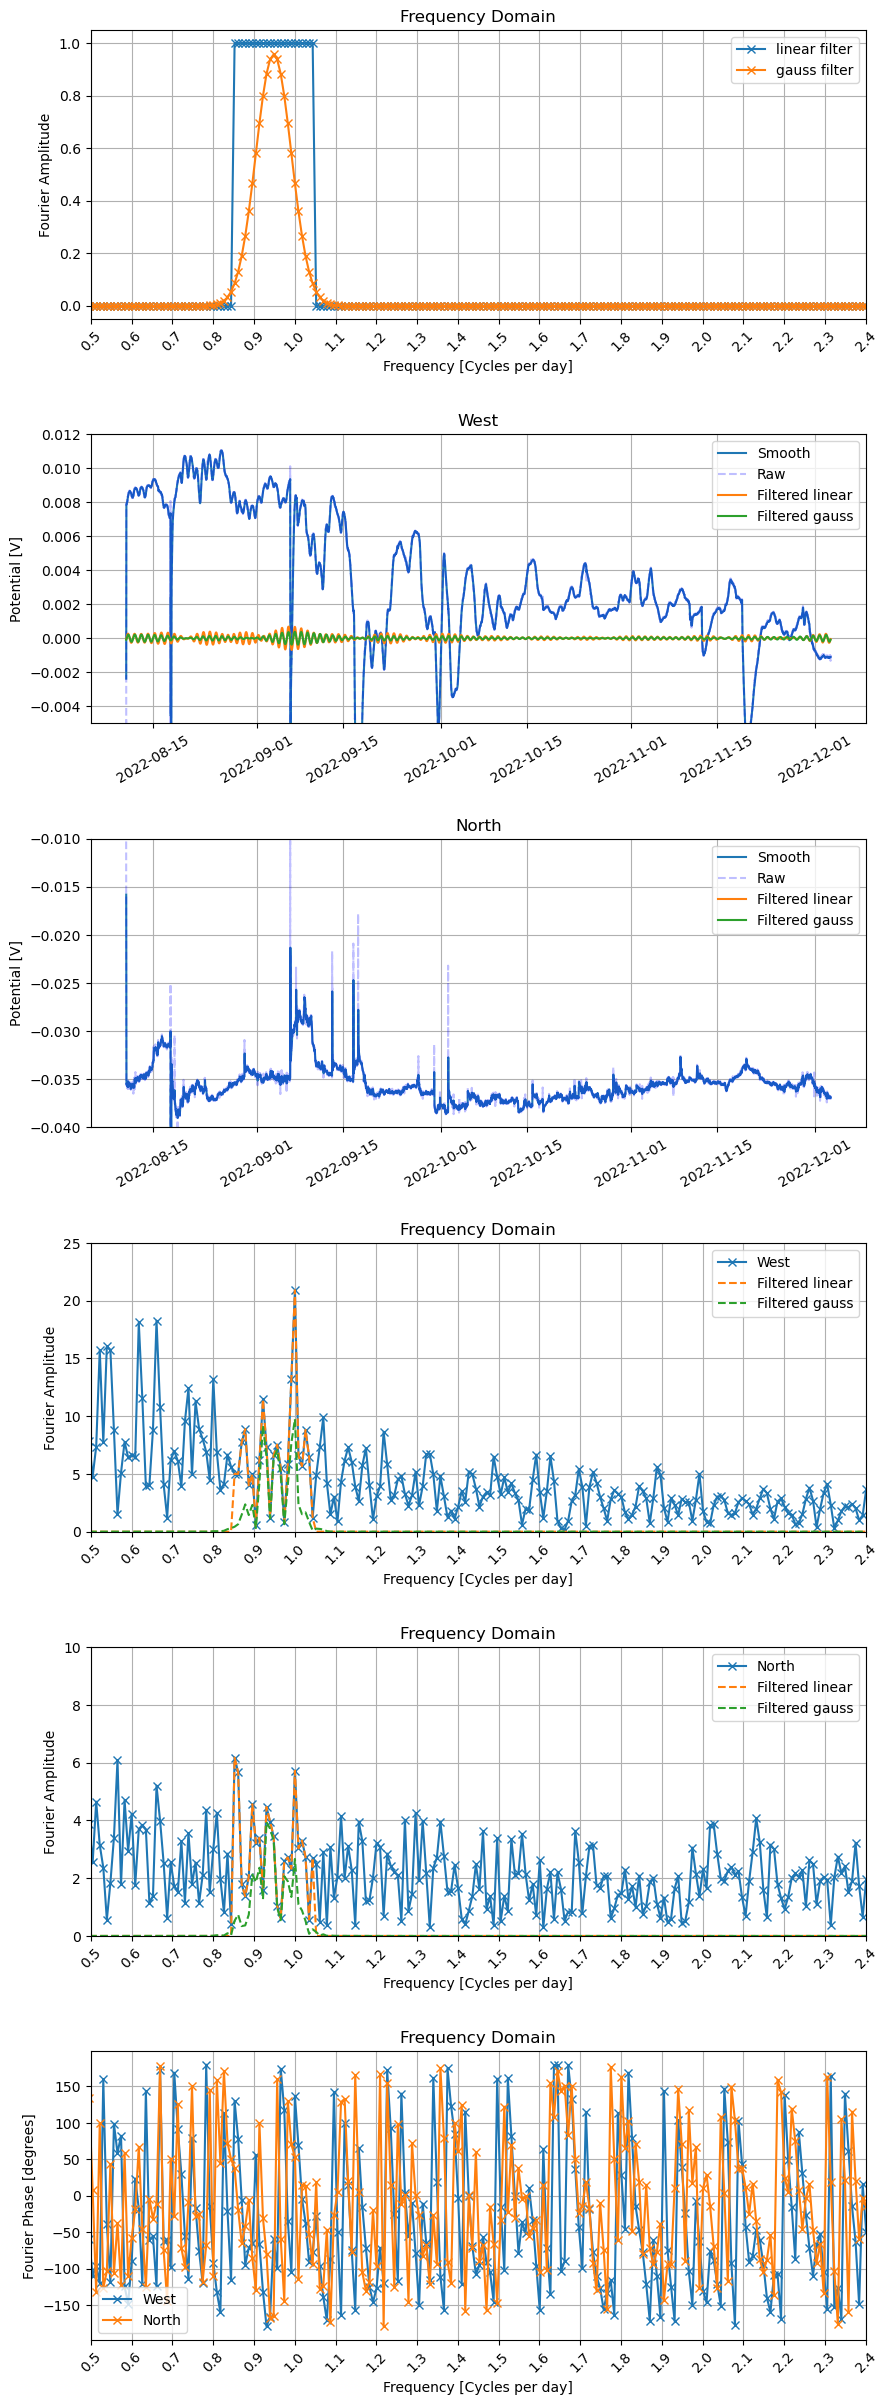

In [96]:
start_date = datetime.datetime(2022,8,18,15,1,30)
end_date = datetime.datetime(2022,12,3,23,30)

si = 60

geolore_data_west = df_60s_smooth.iloc[:,2]

X_data_west = geolore_data_west.values
N_data_west = len(X_data_west)
F_data_west = np.fft.fft(X_data_west)
#F_data_detrended_west = np.fft.fft(signal.detrend(geolore_data_west.iloc[:,2]))/N_data_west

F_freq_data_west = np.fft.fftfreq(N_data_west, d=si)
one_side_west = N_data_west//2

geolore_data_north = df_60s_smooth.iloc[:,1]

X_data_north = geolore_data_north.values
N_data_north = len(X_data_north)
F_data_north = np.fft.fft(X_data_north)
#F_data_detrended_north = np.fft.fft(signal.detrend(geolore_data_north.iloc[:,1]))/N_data_north

F_freq_data_north = np.fft.fftfreq(N_data_north, d=si)
one_side_north = N_data_north//2

#____________________________________________________FILTER_______________________________________________________

amplitude_filter_negative = 0
amplitude_filter_positive = 1


filter_high_cpd = 1.05
filter_low_cpd = 0.85
cpd_conv = 24*60*60

filter_index = np.where( ((F_freq_data_north < filter_high_cpd/cpd_conv) & 
           (F_freq_data_north > filter_low_cpd/cpd_conv ) ))


filter_array = np.ones(len(F_data_west))* amplitude_filter_negative
filter_array[filter_index] = amplitude_filter_positive

pdf_mean = norm.pdf(np.arange(0,len(F_freq_data_north)),np.mean(filter_index),5)*12 \
* amplitude_filter_positive + amplitude_filter_negative


F_data_west_filtered_fft = F_data_west * filter_array
F_data_west_filtered_fft_2 = F_data_west * pdf_mean

F_data_west_filtered = np.fft.ifft(F_data_west_filtered_fft)
F_data_west_filtered_2 = np.fft.ifft(F_data_west_filtered_fft_2)

F_data_north_filtered_fft = F_data_north * filter_array
F_data_north_filtered_fft_2 = F_data_north * pdf_mean

F_data_north_filtered = np.fft.ifft(F_data_north_filtered_fft)
F_data_north_filtered_2 = np.fft.ifft(F_data_north_filtered_fft_2)



#_________________________________________________________________________________________________________________


fig , axes = plt.subplots(6, figsize=(10,30))
plt.subplots_adjust(hspace= 0.4)

ax = axes[0]

ax.plot(F_freq_data_north[:one_side_west], filter_array[:one_side_west], "x-", label="linear filter")
ax.plot(F_freq_data_north[:one_side_west], pdf_mean[:one_side_west], "x-", label="gauss filter")

x_freq_cpd = np.arange(0.5,2.5,0.1)
x_freq_hz = x_freq_cpd/(24*60*60)
ax.set_xlim(x_freq_hz[0], x_freq_hz[-1])
ax.set_xticks(x_freq_hz, labels= np.round(x_freq_cpd,1))
ax.tick_params('x',rotation=45)
ax.set_xlabel("Frequency [Cycles per day]")
ax.set_title('Frequency Domain')
ax.set_ylabel("Fourier Amplitude")
ax.grid()
ax.legend()

ax = axes[1]

ax.plot(df_60s_smooth.index, df_60s_smooth.iloc[:,2], label="Smooth")
ax.plot(df_60s.index, df_60s.iloc[:,2], "--", label="Raw", alpha=0.25, color="blue")
ax.plot(geolore_data_west.index, F_data_west_filtered, label="Filtered linear")
ax.plot(geolore_data_west.index, F_data_west_filtered_2, label="Filtered gauss")

ax.set_title("West")
ax.set_ylabel('Potential [V]')
ax.set_ylim(-0.005,0.012)
ax.tick_params(axis ='x', labelrotation =30)
ax.grid()
ax.legend()

ax = axes[2]

ax.plot(df_60s_smooth.index, df_60s_smooth.iloc[:,1], label="Smooth")
ax.plot(df_60s.index, df_60s.iloc[:,1], "--", label="Raw", alpha=0.25, color="blue")
ax.plot(geolore_data_north.index, F_data_north_filtered, label="Filtered linear")
ax.plot(geolore_data_north.index, F_data_north_filtered_2, label="Filtered gauss")


ax.set_title("North")
ax.set_ylabel('Potential [V]')
ax.set_ylim(-0.04, -0.01)
ax.tick_params(axis ='x', labelrotation =30)
ax.grid()
ax.legend()


ax = axes[3]

ax.plot(F_freq_data_west[:one_side_west], np.abs(F_data_west[:one_side_west]),
        'x-', label='West')


ax.plot(F_freq_data_west[:one_side_west], np.abs(F_data_west_filtered_fft[:one_side_west]),
        '--', label='Filtered linear')

ax.plot(F_freq_data_west[:one_side_west], np.abs(F_data_west_filtered_fft_2[:one_side_west]),
        '--', label='Filtered gauss')

ax.set_ylim(0,25)
#ax1.set_ylim(0,0.001)
x_freq_cpd = np.arange(0.5,2.5,0.1)
x_freq_hz = x_freq_cpd/(24*60*60)
ax.set_xlim(x_freq_hz[0], x_freq_hz[-1])
ax.set_xticks(x_freq_hz, labels= np.round(x_freq_cpd,1))
ax.tick_params('x',rotation=45)
ax.set_xlabel("Frequency [Cycles per day]")
ax.set_title('Frequency Domain')
ax.set_ylabel("Fourier Amplitude")
ax.legend()    
ax.grid()

ax = axes[4]

ax.plot(F_freq_data_north[:one_side_north], np.abs(F_data_north[:one_side_north]),
        'x-', label='North')


ax.plot(F_freq_data_north[:one_side_north], np.abs(F_data_north_filtered_fft[:one_side_north]),
        '--', label='Filtered linear')

ax.plot(F_freq_data_north[:one_side_north], np.abs(F_data_north_filtered_fft_2[:one_side_north]),
        '--', label='Filtered gauss')

ax.set_ylim(0,10)
x_freq_cpd = np.arange(0.5,2.5,0.1)
x_freq_hz = x_freq_cpd/(24*60*60)
ax.set_xlim(x_freq_hz[0], x_freq_hz[-1])
ax.set_xticks(x_freq_hz, labels= np.round(x_freq_cpd,1))
ax.tick_params('x',rotation=45)
ax.set_xlabel("Frequency [Cycles per day]")
ax.set_title('Frequency Domain')
ax.set_ylabel("Fourier Amplitude")
ax.legend()    
ax.grid()



ax = axes[5]


ax.plot(F_freq_data_west[:one_side_west], np.angle(F_data_west[:one_side_west])*180/np.pi, 'x-', label='West')

ax.plot(F_freq_data_north[:one_side_north], np.angle(F_data_north[:one_side_north])*180/np.pi,'x-', label='North')


x_freq_cpd = np.arange(0.5,2.5,0.1)
x_freq_hz = x_freq_cpd/(24*60*60)
ax.set_xlim(x_freq_hz[0], x_freq_hz[-1])
ax.set_xticks(x_freq_hz, labels= np.round(x_freq_cpd,1))

ax.tick_params('x',rotation=45)
ax.set_xlabel("Frequency [Cycles per day]")
ax.set_title('Frequency Domain')
ax.set_ylabel("Fourier Phase [degrees]")
ax.legend()    
ax.grid()


#fig.savefig("Output/Forth_back_FFT_filter.pdf")